In [59]:
# Libraries
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from dotenv import load_dotenv
from supabase import create_client
import requests
from typing import Dict, List
import time
import os

def predict_single_car(car_data: pd.DataFrame) -> Dict:
    """
    Make a prediction for a single car using the API.
    
    Args:
        car_data: Dictionary containing car features
        
    Returns:
        Dictionary containing the prediction response
    """
    #url = "http://Gmolinari.pythonanywhere.com/models/predict"
    url = "http://localhost:5328/models/predict"
    headers = {"Content-Type": "application/json"}
    
    try:
        response = requests.post(url, json=car_data, headers=headers)
        return response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error making prediction for car: {car_data}")
        print(f"Error: {str(e)}")
        return {"error": str(e)}

def predict_all_cars(df: pd.DataFrame, delay: float = 0.1) -> List[Dict]:
    """
    Make predictions for all cars in the DataFrame one at a time.
    
    Args:
        df: DataFrame containing car data
        delay: Delay between predictions in seconds
        
    Returns:
        List of prediction results
    """
    results = []
    
    for _, car in df.iterrows():
        car_data = car.to_dict()
        result = predict_single_car(car_data)
        result["car_data"] = car_data
        results.append(result)
        time.sleep(delay)  # Small delay between requests
    
    return results 

In [60]:
# Read data
load_dotenv()

SUPABASE_URL = os.getenv("NEXT_PUBLIC_SUPABASE_URL")
SUPABASE_SERVICE_KEY = os.getenv("NEXT_PUBLIC_SUPABASE_SERVICE_KEY")

supabase = create_client(SUPABASE_URL, SUPABASE_SERVICE_KEY)

response = (
    supabase.table("bat_completed_auctions")
    .select("year, make, model, mileage, normalized_color, transmission, sold_price, bid_amount, end_date, status, url")
    .gte("end_date", datetime.today() - (timedelta(days=30)))
    .eq("country_code", "US")
    .eq("status", "sold")
    .not_.is_("model", None)
    .not_.is_("mileage", None)
    .not_.is_("transmission", None)
    .not_.is_("normalized_color", None)
    .not_.is_("year", None)
    .execute()
)
df = pd.DataFrame(response.data)

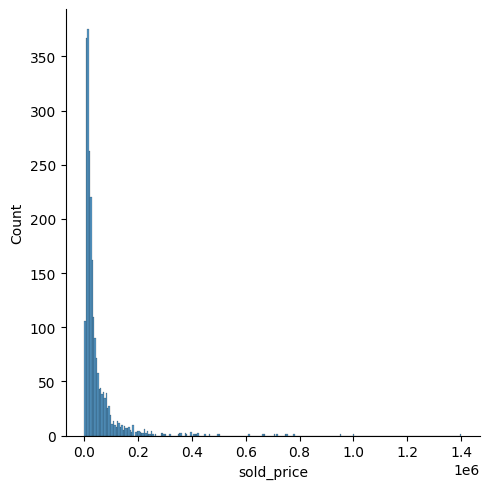

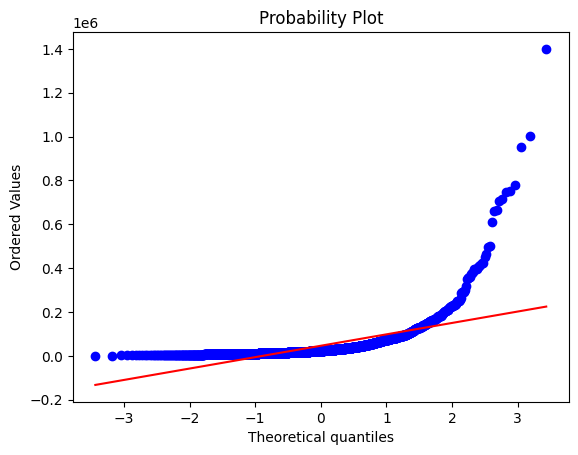

In [61]:
# Replace sold_price with bid_amount and remove outliers
df['sold_price'] = df['sold_price'].fillna(df['bid_amount'])

# Plot distribution of sold_price
sns.displot(df['sold_price'])
fig = plt.figure()
res = stats.probplot(df['sold_price'], plot=plt)


In [62]:
# Prepare target and features
y = df["sold_price"]
X = df.drop(["sold_price","bid_amount","end_date", "status", "url"],axis=1)
X

,year,make,model,mileage,normalized_color,transmission
0,1981,Pontiac,Firebird Trans Am Turbo Special Edition,72000,White,automatic
1,2009,Bimota,DB7,1700,Red,manual
2,1977,Pontiac,Firebird Trans Am 4-Speed,57000,Black,manual
3,1957,Pontiac,Star Chief Custom Catalina Coupe,23000,Red,automatic
4,1996,Alfa Romeo,Spider Twin Spark,40000,Blue,manual
...,...,...,...,...,...,...
2342,1992,Volvo,240 GL Sedan,153000,Blue,automatic
2343,2013,Volvo,XC70 T6,114000,Black,automatic
2344,1951,Willys,M38,89,Gray,manual
2345,1986,Citroen,2CV6 Charleston,61000,Gray,manual


In [63]:
print("Starting predictions...")

results = predict_all_cars(X, delay=0.1)
predictions_df = pd.DataFrame(results)
analysis = pd.merge(df, predictions_df, how='outer', left_index=True, right_index=True)


Starting predictions...


<Axes: xlabel='sold_price', ylabel='prediction'>

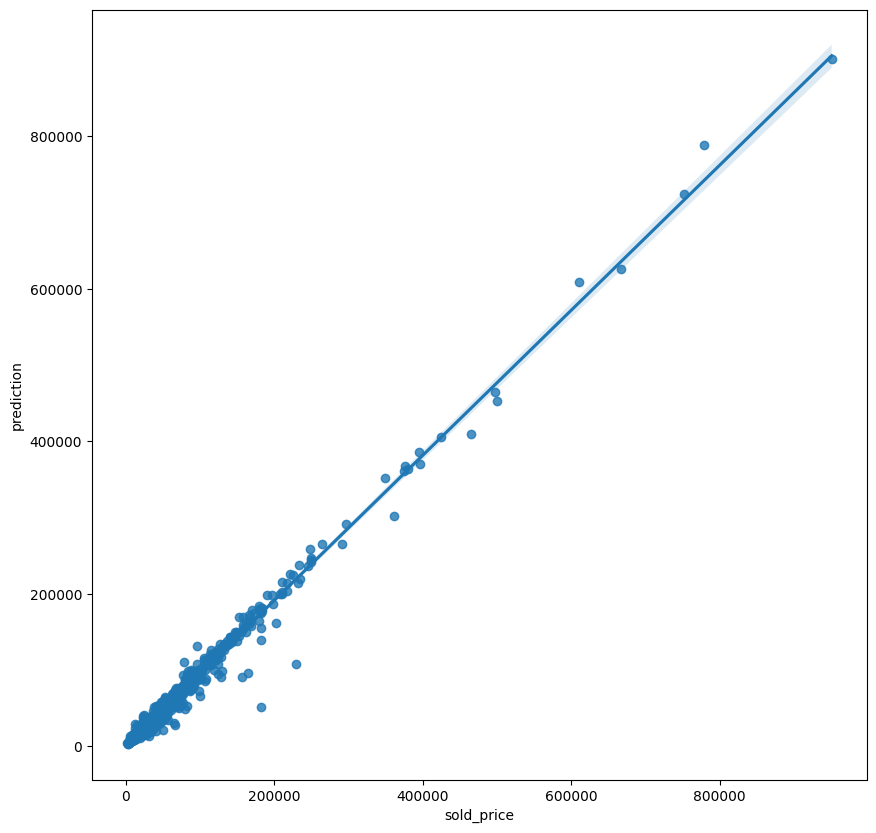

In [64]:
# Plot true vs predicted values scatter
plt.figure(figsize = (10, 10))
sns.regplot(x=analysis.sold_price, y=analysis.prediction)

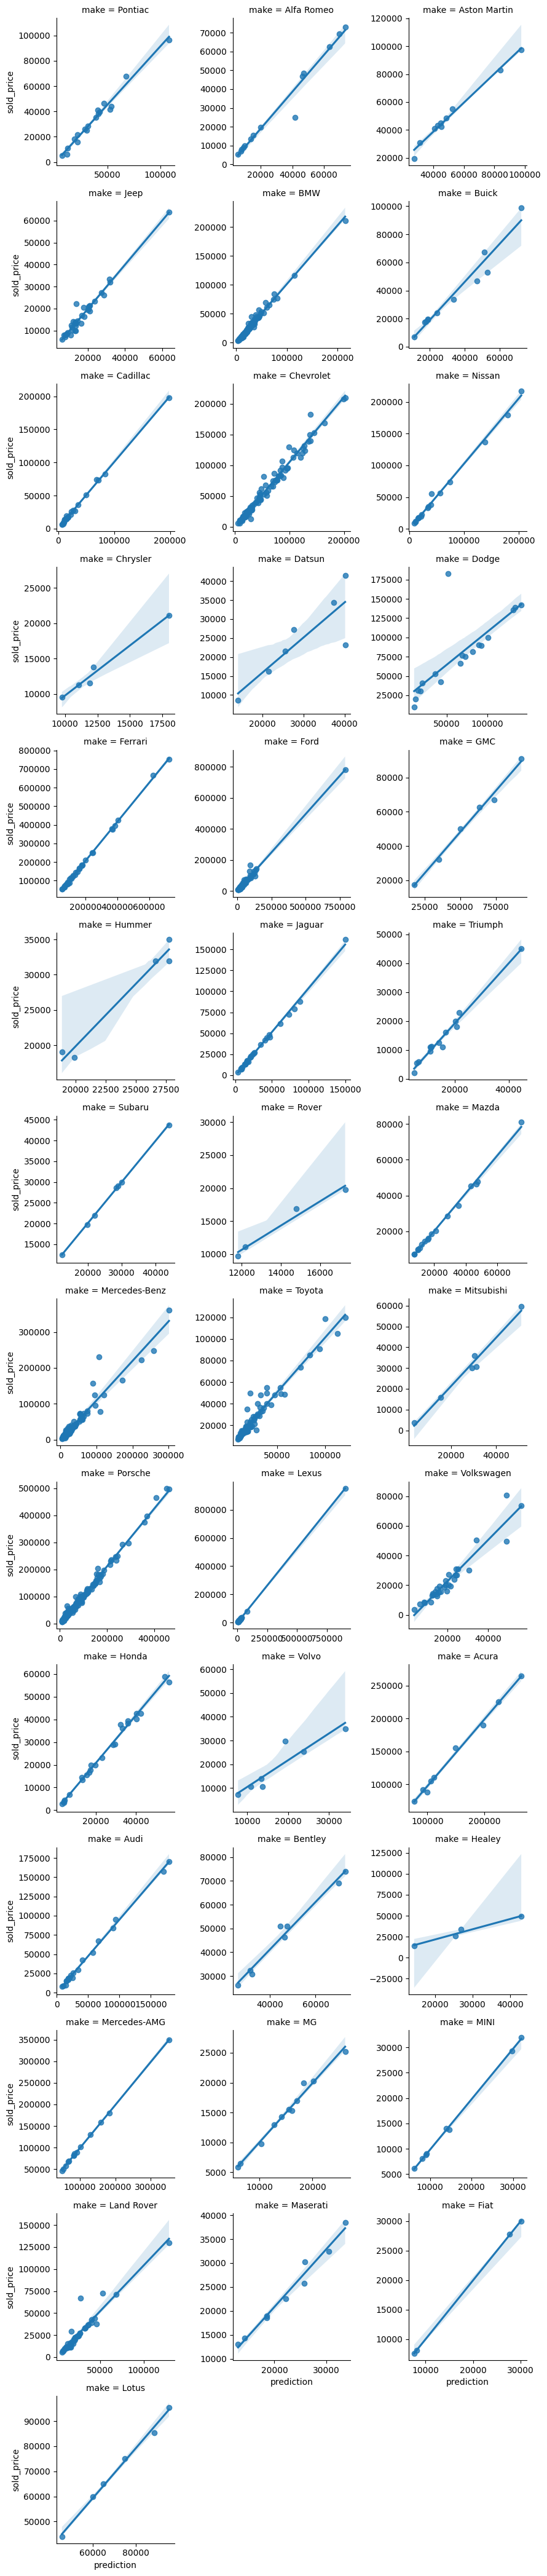

In [73]:
counts = analysis['prediction'].groupby(df['make']).count()
frequent = counts[counts >= 4].index
filter = analysis[df['make'].isin(frequent)]

# Predicted vs Sold Price Scatter by model
g = sns.FacetGrid(filter, col="make", col_wrap=3, sharex=False, sharey=False)

# Map scatter plots to the grid
g.map(sns.regplot, "prediction", "sold_price")